In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
# from dynamic_routing_analysis import decoding_utils
# from dynamic_routing_analysis import plot_utils
# import dynamic_routing_analysis as dra
# import pingouin as pg
import os

import matplotlib
import matplotlib.font_manager as fm

matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
fm.FontProperties().set_family('arial')

%load_ext autoreload
%autoreload 2
%matplotlib inline
# %matplotlib widget

In [2]:
results_path = "s3://aind-scratch-data/dynamic-routing/decoding/results/time_mod_keep_units_consistent_0/" # 20 units; all sessions

save_path = r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\time_mod_keep_units_consistent_0_2025-06-15\coef_correlation_by_session"

In [6]:
session_table_path=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\session_table_v0.268.csv"
# session_table_path="/Users/ethan.mcbride/Data/DR/session_table_v0.265.csv"
session_table=pl.read_csv(session_table_path)

all_session_list=(
    session_table.filter(
    # pl.col('project')=="DynamicRouting",
    pl.col('is_production'),
    pl.col('is_annotated'),
    pl.col('issues')=="",
    # pl.col('is_good_behavior').eq(True),
    )['session_id'].to_list()
    )

In [4]:
#define grouping columns
grouping_cols = {
    'session_id',
    'structure',
    'electrode_group_names',
    'unit_subsample_size',
    'bin_center',
    'bin_size',
    'time_aligned_to',
    'coefs',
    'unit_ids',
}

#toggle combine_multi_probe_rec
combine_multi_probe_rec = True

if combine_multi_probe_rec:
    combine_multi_probe_expr = pl.col('electrode_group_names').list.len().gt(1) | pl.col('is_sole_recording').eq(True)
else:
    combine_multi_probe_expr = pl.col('electrode_group_names').list.len().eq(1) | pl.col('is_sole_recording').eq(True)


In [9]:
#functions for getting results and computing correlations

def get_session_results(session_id,results_path,grouping_cols,combine_multi_probe_expr):

    decoder_coefs = (
        pl.scan_parquet(results_path)
        .filter(
            pl.col('session_id').eq(session_id),
        )
        .with_columns(
            pl.col('electrode_group_names').flatten().n_unique().eq(1).over(grouping_cols - {'electrode_group_names'}).alias('is_sole_recording'),     
        )
        .filter(
            combine_multi_probe_expr,
            pl.col('is_all_trials').eq(True),
        )
        .sort('structure', 'shift_idx', 'repeat_idx', 'time_aligned_to', 'bin_center', descending=False, maintain_order=True)
        .with_columns([
            pl.col("electrode_group_names").list.n_unique().alias("n_probes"),
            pl.col("electrode_group_names")
            .list.eval(pl.element().str.replace("probe", ""))
            .list.join("")
            .alias("probe")
        ])
        .collect()
    )

    return decoder_coefs.to_pandas()


def compute_decoder_coef_correlations(decoder_coefs_pd, save_path):
    """
    Compute the correlation of decoder coefficients across time bins for each session.
    """

    corr_coefs_by_area_probe = {
        'session_id':[],
        'structure':[],
        'probe':[],
        'shift_idx':[],
        'comp_idx':[],
        'bin_center':[],
        'corr_coefs':[],
    }

    sel_time_aligned_to='stim_start_time'
    # sel_repeat=0
    sel_shift_idx=np.nan

    session_id= decoder_coefs_pd['session_id'].unique()
    if len(session_id) > 1:
        print(f"Warning: More than one session_id found in decoder_coefs_pd: {session_id}. Using the first one.")
    sel_session = session_id[0]

    print(f'computing decoder coefficient correlations for {session_id}')

    for sel_structure in decoder_coefs_pd['structure'].unique():
        unique_probes=decoder_coefs_pd.query('structure==@sel_structure')['probe'].unique()

        for sel_comp_ind in range(len(decoder_coefs_pd['bin_center'].unique())):

            for sel_probe_ind in range(len(unique_probes)):

                all_corr_coefs = []

                for sel_repeat in decoder_coefs_pd['repeat_idx'].unique():

                    if len(unique_probes)>sel_probe_ind:
                        probe_str=unique_probes[sel_probe_ind]
                    else:
                        probe_str=unique_probes[0]

                    # shift_inds = decoder_coefs_pd['shift_idx'].unique()

                    sel_rows=decoder_coefs_pd.query(f'structure == "{sel_structure}" and shift_idx.isna() and \
                                                    repeat_idx == {sel_repeat} and time_aligned_to == "{sel_time_aligned_to}"')
                    
                    if len(unique_probes)>1:
                        sel_rows=sel_rows.query('probe==@probe_str')
                    
                    initial_coefs=sel_rows['coefs'].values[sel_comp_ind]
                    initial_unit_ids=sel_rows['unit_ids'].values[sel_comp_ind]

                    corr_coefs=[]

                    for idx, row in sel_rows.iterrows():
                        
                        unit_ids=np.sort(row['unit_ids'])
                        coefs=row['coefs']
                        
                        if np.array_equal(np.sort(initial_unit_ids), unit_ids):
                            corr_coefs.append(np.corrcoef(initial_coefs, coefs)[0,1])
                        else:
                            print(f"Unit ids in time bin {row['bin_center']} do not match initial bin in \n repeat {sel_repeat}, structure {sel_structure}, shift_idx {sel_shift_idx}, time_aligned_to {sel_time_aligned_to}")
                            corr_coefs.append(np.nan)

                    all_corr_coefs.append(np.array(corr_coefs))

                # corr_coefs_by_area_probe[sel_structure+'_'+probe_str] = np.array(corr_coefs)
                corr_coefs_by_area_probe['session_id'].append(sel_session)
                corr_coefs_by_area_probe['structure'].append(sel_structure)
                corr_coefs_by_area_probe['probe'].append(probe_str)
                corr_coefs_by_area_probe['shift_idx'].append(sel_shift_idx)
                corr_coefs_by_area_probe['comp_idx'].append(sel_comp_ind)
                corr_coefs_by_area_probe['bin_center'].append(sel_rows['bin_center'].values[sel_comp_ind])
                corr_coefs_by_area_probe['corr_coefs'].append(np.nanmean(np.vstack(all_corr_coefs),axis=0))

    corr_coefs_by_area_probe = pd.DataFrame(corr_coefs_by_area_probe)

    corr_coefs_by_area_probe.to_parquet(os.path.join(save_path, f"decoder_coef_correlations_{sel_session}.parquet"), index=False)




In [ ]:
for session_id in all_session_list[:]:
    print(f"Processing session {session_id}")
    decoder_coefs_pd = get_session_results(session_id, results_path, grouping_cols, combine_multi_probe_expr)
    
    if not decoder_coefs_pd.empty:
        try:
            compute_decoder_coef_correlations(decoder_coefs_pd, save_path)
        except:
            print(f"Error processing session {session_id}. Skipping.")
    else:
        print(f"No results found for session {session_id}. Skipping.")



Processing session 703333_2024-04-09
computing decoder coefficient correlations for ['703333_2024-04-09']
Error processing session 703333_2024-04-09. Skipping.
Processing session 703333_2024-04-10
computing decoder coefficient correlations for ['703333_2024-04-10']
Processing session 703333_2024-04-11
computing decoder coefficient correlations for ['703333_2024-04-11']
Processing session 699847_2024-04-15
computing decoder coefficient correlations for ['699847_2024-04-15']
Processing session 703880_2024-04-15
computing decoder coefficient correlations for ['703880_2024-04-15']
Processing session 699847_2024-04-16
computing decoder coefficient correlations for ['699847_2024-04-16']
Processing session 703880_2024-04-16
computing decoder coefficient correlations for ['703880_2024-04-16']
Processing session 699847_2024-04-17
computing decoder coefficient correlations for ['699847_2024-04-17']
Processing session 703880_2024-04-17
computing decoder coefficient correlations for ['703880_2024-

In [13]:
all_session_list[85]

# session_id

'703333_2024-04-09'

In [37]:
load_path = r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\time_mod_keep_units_consistent_0_2025-06-15\coef_correlation_by_session"

sel_session_list =(
    session_table.filter(
    pl.col('project')=="DynamicRouting",
    pl.col('is_production'),
    pl.col('is_annotated'),
    pl.col('issues')=="",
    pl.col('is_good_behavior').eq(True),
    )['session_id'].to_list()
    )

coef_corr_by_area_session_df = (
    pl.scan_parquet(load_path).filter(
        pl.col('session_id').is_in(sel_session_list),
        pl.col('probe').str.len_chars() == 1,
    ).sort(
        pl.col('session_id'), 
        pl.col('structure'), 
        pl.col('bin_center')
    ).collect()
)

In [38]:
coef_corr_by_area_session_pd = coef_corr_by_area_session_df.to_pandas()

In [40]:
coef_corr_by_area_session_pd.query('comp_idx==0')

,session_id,structure,probe,shift_idx,comp_idx,bin_center,corr_coefs
0,626791_2022-08-15,AUDp,C,NaN,0,-1.25,"[1.0, 0.7023017295552846, 0.6982240829658841, ..."
14,626791_2022-08-15,AUDpo,C,NaN,0,-1.25,"[1.0, 0.7003232309287813, 0.6770750485781335, ..."
28,626791_2022-08-15,CA1,B,NaN,0,-1.25,"[1.0, 0.7034027434691339, 0.673445308084083, 0..."
29,626791_2022-08-15,CA1,C,NaN,0,-1.25,"[1.0, 0.749061952998471, 0.6199898100688814, 0..."
56,626791_2022-08-15,CP,F,NaN,0,-1.25,"[1.0, 0.6259404732194387, 0.5437770182447837, ..."
...,...,...,...,...,...,...,...
18860,761583_2024-12-17,SSp,F,NaN,0,-1.25,"[1.0, 0.3814574354095376, 0.4212380062647179, ..."
18861,761583_2024-12-17,SSp,B,NaN,0,-1.25,"[1.0, 0.46021523782005647, 0.33750567913255636..."
18914,761583_2024-12-17,VISam,C,NaN,0,-1.25,"[1.0, 0.6622219337975647, 0.5014579467534057, ..."
18928,761583_2024-12-17,VISli,D,NaN,0,-1.25,"[1.0, 0.5267649358861604, 0.2384491231643855, ..."


In [53]:
unique_bin_centers = coef_corr_by_area_session_pd['bin_center'].unique()
unique_bin_centers

array([-1.25, -0.75, -0.25,  0.25,  0.75,  1.25,  1.75,  2.25,  2.75,
        3.25,  3.75,  4.25,  4.75,  5.25])

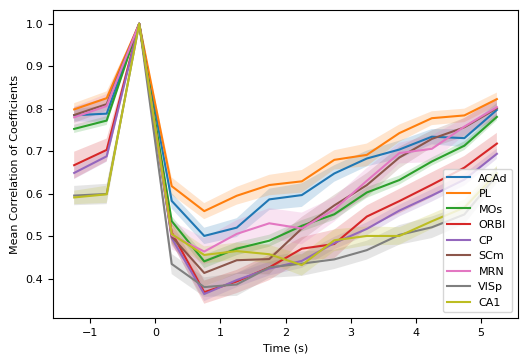

In [64]:
#plot mean/sem of unique areas

sel_structures=['ACAd','PL','MOs','ORBl','CP','SCm','MRN','VISp','CA1']
sel_comp_idx = 2

fig,ax=plt.subplots(figsize=(6, 4))
for sel_structure in sel_structures: #coef_corr_by_area_session_pd['structure'].unique():
    sel_df = coef_corr_by_area_session_pd.query(f'structure == "{sel_structure}" and comp_idx=={sel_comp_idx}')
    if len(sel_df)<10:
        continue
    mean_corr = np.mean(np.vstack(sel_df['corr_coefs'].values),axis=0)
    sem_corr = stats.sem(sel_df['corr_coefs'])

    ax.plot(unique_bin_centers, mean_corr, label=sel_structure)
    ax.fill_between(
        unique_bin_centers,
        mean_corr - sem_corr,
        mean_corr + sem_corr,
        alpha=0.2
    )

ax.set_xlabel('Time (s)')
ax.set_ylabel('Mean Correlation of Coefficients')
ax.legend(loc='lower right')

In [47]:
sel_df

,session_id,structure,probe,shift_idx,comp_idx,bin_center,corr_coefs
56,626791_2022-08-15,CP,F,NaN,0,-1.25,"[1.0, 0.6259404732194387, 0.5437770182447837, ..."
57,626791_2022-08-15,CP,F,NaN,1,-0.75,"[0.6259404732194387, 1.0, 0.48676199004076637,..."
58,626791_2022-08-15,CP,F,NaN,2,-0.25,"[0.5437770182447836, 0.48676199004076637, 1.0,..."
59,626791_2022-08-15,CP,F,NaN,3,0.25,"[0.5137551531761868, 0.5676298883086589, 0.470..."
60,626791_2022-08-15,CP,F,NaN,4,0.75,"[0.540195446898679, 0.4994106140772599, 0.4327..."
...,...,...,...,...,...,...,...
18769,761583_2024-12-17,CP,A,NaN,12,4.75,"[0.8347017532804689, 0.730920435135857, 0.7241..."
18770,761583_2024-12-17,CP,F,NaN,12,4.75,"[0.6591994067970144, 0.6061859823184047, 0.573..."
18771,761583_2024-12-17,CP,B,NaN,13,5.25,"[0.4235512758344911, 0.3275190553863351, 0.356..."
18772,761583_2024-12-17,CP,A,NaN,13,5.25,"[0.6770388111819698, 0.795038647599731, 0.7797..."
